In [1]:
import os
import random
import h5py
import numpy as np
import pandas as pd
import scipy as sp
import scanpy as sc
import matplotlib.pyplot as plt
from scvi.dataset import AnnDatasetFromAnnData
from scvic.dataset import ExpressionDataset
from scvic.models import CVAE
from scvic.inference import CTrainer
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import scanpy as sc
import anndata
import torch

# Control UMAP numba warnings
import warnings; warnings.simplefilter('ignore')

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

%matplotlib inline 

# Sets torch and numpy random seeds, run after all scvi imports
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) 

/data/xiong/anaconda3/envs/scVIC/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def getNClusters(data, n_cluster, range_min=0, range_max=4, max_steps=20, verbose=False):
    if isinstance(data, np.ndarray):
        data = anndata.AnnData(X=data)
    assert isinstance(data, anndata.AnnData), \
        "data must be numpy.ndarray or anndata.AnnData"
    this_min = range_min
    this_max = range_max
    for this_step in range(max_steps):
        if verbose:
            print("step: " + str(this_step))
        this_resolution = this_min + ((this_max-this_min)/2)
        sc.pp.neighbors(data)
        sc.tl.louvain(data, resolution=this_resolution)
        this_clusters = len(np.unique(data.obs['louvain']))
        if verbose:
            print('got ' + str(this_clusters) + ' at resolution ' + str(this_resolution))
        if this_clusters > n_cluster:
            this_max = this_resolution
        if this_clusters < n_cluster:
            this_min = this_resolution
        if this_clusters == n_cluster:
            if not verbose:
                print('got ' + str(this_clusters) + ' at resolution ' + str(this_resolution))
            return data
    print('Cannot find the number of clusters')

In [3]:
h5_path = "../Datasets/Extracted_h5_Datasets/Quake_10x_Trachea/data.h5"

class dotdict(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
def empty_safe(fn, dtype):
    def _fn(x):
        if x.size:
            return fn(x)
        return x.astype(dtype)
    return _fn

decode = empty_safe(np.vectorize(lambda _x: _x.decode("utf-8")), str)

def read_clean(data):
    assert isinstance(data, np.ndarray)
    if data.dtype.type is np.bytes_:
        data = decode(data)
    if data.size == 1:
        data = data.flat[0]
    return data

def dict_from_group(group):
    assert isinstance(group, h5py.Group)
    d = dotdict()
    for key in group:
        if isinstance(group[key], h5py.Group):
            value = dict_from_group(group[key])
        else:
            value = read_clean(group[key][...])
        d[key] = value
    return d

def read_data(filename, sparsify = False, skip_exprs = False):
    with h5py.File(filename, "r") as f:
        obs = pd.DataFrame(dict_from_group(f["obs"]), index = decode(f["obs_names"][...]))
        var = pd.DataFrame(dict_from_group(f["var"]), index = decode(f["var_names"][...]))
        uns = dict_from_group(f["uns"])
        if not skip_exprs:
            exprs_handle = f["exprs"]
            if isinstance(exprs_handle, h5py.Group):
                mat = sp.sparse.csr_matrix((exprs_handle["data"][...], exprs_handle["indices"][...],
                                               exprs_handle["indptr"][...]), shape = exprs_handle["shape"][...])
            else:
                mat = exprs_handle[...].astype(np.float32)
                if sparsify:
                    mat = sp.sparse.csr_matrix(mat)
        else:
            mat = sp.sparse.csr_matrix((obs.shape[0], var.shape[0]))
    return mat, obs, var, uns

mat, obs, var, uns = read_data(h5_path, sparsify=False, skip_exprs=False)

if isinstance(mat, np.ndarray):
    X = np.array(mat)
else:
    X = np.array(mat.toarray())
X = np.ceil(X).astype(np.int)    
cell_name = np.array(obs["cell_type1"])
adata = sc.AnnData(X)
adata.obs['cell_types'] = cell_name

In [4]:
gene_dataset = AnnDatasetFromAnnData(adata)
gene_dataset.subsample_genes(1000)
gene_dataset.make_gene_names_lower()
trachea_dataset = ExpressionDataset()
trachea_dataset.load_dataset_from_scVI(gene_dataset)

[2022-09-18 09:37:59,247] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2022-09-18 09:37:59,250] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2022-09-18 09:38:01,738] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2022-09-18 09:38:02,097] INFO - scvi.dataset.dataset | Downsampled from 11269 to 11269 cells
[2022-09-18 09:38:02,101] INFO - scvi.dataset.dataset | extracting highly variable genes using seurat_v3 flavor
[2022-09-18 09:38:06,595] INFO - scvi.dataset.dataset | Downsampling from 23341 to 1000 genes
[2022-09-18 09:38:06,773] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2022-09-18 09:38:06,804] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2022-09-18 09:38:06,926] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2022-09-18 09:38:06,948] INFO - scvi.dataset.dataset | Downsampled from 11269 to 11269 cells
[2022-09-18 09:38:06,950] INFO - scvi.dataset.d

In [5]:
n_epochs = 400
lr = 0.001
use_cuda = True

In [6]:
trachea_cvae = CVAE(trachea_dataset.nb_genes, n_labels=trachea_dataset.n_labels, n_latent=10)
ctrainer = CTrainer(
    trachea_cvae,
    trachea_dataset,
    train_size=1.0,
    use_cuda=use_cuda,
    n_epochs_kl_warmup=200,
    n_epochs_pre_train=200
)

ctrainer.train(n_epochs=n_epochs, lr=lr)

[2022-09-18 09:38:15,945] INFO - scvi.inference.inference | KL warmup for 200 epochs
training: 100%|███████████████████████████████| 400/400 [09:53<00:00,  1.48s/it]


In [7]:
full = ctrainer.create_posterior(ctrainer.model, trachea_dataset, indices=np.arange(len(trachea_dataset)))
# Updating the "minibatch" size after training is useful in low memory configurations
full = full.update({"batch_size":32})
latent, _ = full.sequential().get_latent()
data = getNClusters(latent, n_cluster=trachea_dataset.n_labels)
labels_pred = data.obs["louvain"].astype(int)

got 5 at resolution 0.0625


In [8]:
post_adata = anndata.AnnData(X=trachea_dataset.X)
post_adata.obsm["X_scVIC"] = latent
post_adata.obs['cell_type'] = np.array([trachea_dataset.cell_types[trachea_dataset.labels[i][0]]  
                                        for i in range(post_adata.n_obs)])
labels_pred=pd.Series(labels_pred, index=post_adata.obs.index, dtype='category')
labels_pred.cat.categories=list(range(len(labels_pred.unique())))
post_adata.obs['predicted_type'] = labels_pred
sc.pp.neighbors(post_adata, use_rep="X_scVIC", n_neighbors=15)
sc.tl.umap(post_adata, min_dist=0.3)
show_plot = True

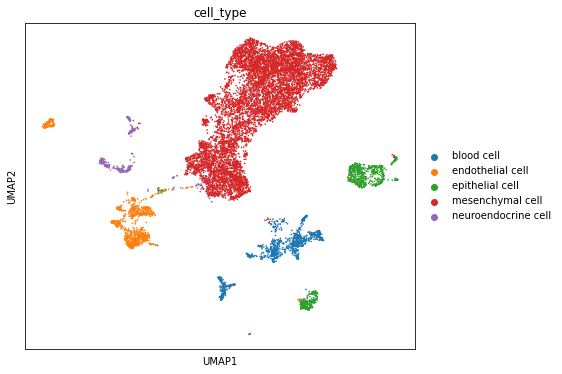

In [9]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["cell_type"], ax=ax, show=show_plot)

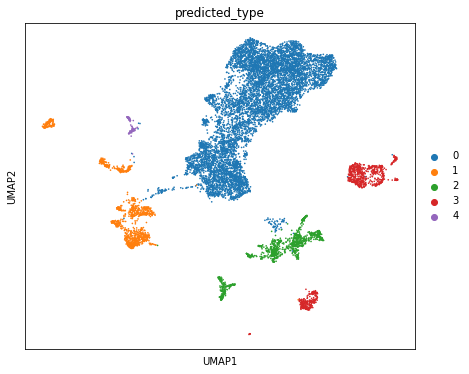

In [10]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["predicted_type"], ax=ax, show=show_plot)

In [11]:
ARI = np.around(adjusted_rand_score(trachea_dataset.labels.squeeze(), labels_pred), 5)
print("Trachea_scVIC_Louvain_ARI: ")
print(ARI)
NMI = np.around(normalized_mutual_info_score(trachea_dataset.labels.squeeze(), labels_pred, average_method='arithmetic'), 5)
print("Trachea_scVIC_Louvain_NMI: ")
print(NMI)        

Trachea_scVIC_Louvain_ARI: 
0.94379
Trachea_scVIC_Louvain_NMI: 
0.87011


In [12]:
saved_data = anndata.AnnData(X=latent)
saved_data.obs['cell_type'] = post_adata.obs['cell_type']
saved_data.obs['predicted_type'] = post_adata.obs['predicted_type']
saved_data.obsm["default_visualization"] = post_adata.obsm["X_umap"]
saved_data.uns["ari"] = ARI
saved_data.uns["nmi"] = NMI
saved_data.uns["default_visualization_method"] = 'umap'
saved_data.write_h5ad("../Saved_Data/scVIC_Louvain/Trachea_scVIC_Louvain.h5")